***Méthodes numériques, PHYS-F302 (Module 5).***
*********************************
Stokes-flow in a square cavity.
==
### But #
Résoudre le système couplé d'équations suivant:
\begin{equation}
\nabla^2 \omega = 0
\end{equation}

\begin{equation}
\nabla^2 \psi = -\omega
\end{equation} 
à l'aide des différentes méthodes itératives apprises dans ce module (itération de Jacobi, de Gauss-Seidel, SOR, Steepest Descent et Gradients conjugués).



## 1. Itération de Jacobi
On commence par cette méthode parce que c'est la plus simple à comprendre. On verra ensuite qu'elle est peu efficace et on la comparera aux autres méthodes.

In [1]:
from matplotlib import pyplot
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [3]:
import numba
from numba import jit

On définit ici deux fonctions qui vont nous permettre de visualiser notre solution, la première par un plot 3D et la seconde par une carte couleur en 2D:

In [4]:
def plot_3D(x, y, p):
    '''Creates 3D plot with appropriate limits and viewing angle
    
    Parameters:
    ----------
    x: array of float
        nodal coordinates in x
    y: array of float
        nodal coordinates in y
    p: 2D array of float
        calculated potential field
    
    '''
    fig = pyplot.figure(figsize=(11,7), dpi=100)
    ax = fig.gca(projection='3d')
    X,Y = numpy.meshgrid(x,y)
    surf = ax.plot_surface(X,Y,p[:], rstride=1, cstride=1, cmap=cm.viridis,
            linewidth=0, antialiased=False)

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$Stream Function (psi)$')
    ax.view_init(30,45)

In [5]:
def colormap(x,y,psi):
    "Creates 2D plot of p in colormap"
    fig=pyplot.figure(figsize=(9,6))
    X,Y = numpy.meshgrid(x,y)
    pyplot.ylim(0,40)
    pyplot.xlim(0,40)
    pyplot.xlabel('x (dx)')
    pyplot.ylabel('y (dy)')
    pyplot.imshow(psi, cmap = cm.viridis)  
    pyplot.title('Streamfunction')
    pyplot.colorbar();

Paramètres du problème:

In [6]:
nx = 41
ny = 41

l = 1.#length of the square in the x-direction 
h = 1.#length of the square in the y-direction

dx = l/(nx-1)
dy = h/(ny-1)

l1_target = 1e-6

Notre condition d'arrêt sera donnée en fonction de la norme L1 de la différence entre deux itérations successives:

In [7]:
def L1norm(new, old):
    norm = numpy.sum(numpy.abs(new-old))
    return norm

Discrétisation des équations par la méthode de Jacobi:
\begin{equation}
\omega^{k+1}_{i,j} = \frac{1}{4} \left(\omega^{k}_{i,j-1} + \omega^k_{i,j+1} + \omega^{k}_{i-1,j} + \omega^k_{i+1,j} \right)
\end{equation}
(valable seulement pour $\Delta x= \Delta y$)
\begin{equation}
\psi_{i,j}^{k+1}=\frac{(\psi_{i+1,j}^{k}+\psi_{i-1,j}^{k})\Delta y^2+(\psi_{i,j+1}^{k}+\psi_{i,j-1}^{k})\Delta x^2+\omega_{i,j}^{k}\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}
\end{equation}


## Conditions au bord:
Ces conditions sont valables pour toutes les méthodes.
- $\psi$ est nul sur les quatres bords du carré
- $\nabla^2 \psi = -\omega$

#### TOP: $\psi=0, \frac{\partial \psi}{\partial y}=1$


$\Rightarrow$
$\frac{\partial \psi^{2}}{\partial y^{2}}=-\omega$ 

$\omega_{i,j}=\frac{-1}{2\Delta y^{2}}\left(8\psi_{i,j-1}-\psi_{i,j-2}\right)-\frac{3}{\Delta y}$

#### RIGHT: $\psi=0, \frac{\partial \psi}{\partial x}=0$


$\Rightarrow$
$\frac{\partial \psi^{2}}{\partial x^{2}}=-\omega$ 

$\omega_{i,j}=\frac{-1}{2\Delta x^{2}}\left(8\psi_{i-1,j}-\psi_{i-2,j}\right)$

#### LEFT: $\psi=0, \frac{\partial \psi}{\partial x}=0$


$\Rightarrow$
$\frac{\partial \psi^{2}}{\partial x^{2}}=-\omega$ 

$\omega_{i,j}=\frac{-1}{2\Delta x^{2}}\left(8\psi_{i+1,j}-\psi_{i+2,j}\right)$

#### BOTTOM: $\psi=0, \frac{\partial \psi}{\partial y}=0$


$\Rightarrow$
$\frac{\partial \psi^{2}}{\partial y^{2}}=-\omega$ 

$\omega_{i,j}=\frac{-1}{2\Delta y^{2}}\left(8\psi_{i,j+1}-\psi_{i,j+2}\right)$





In [8]:
def stokesjacobi(w,psi):
    '''Iteratively solves the Stokes flow equation using the Jacobi method
    
    Parameters:
    ----------
    w: 2D array of float
        Initial vorticity 
    psi: 2D array of floats
        Initial streamfunction
    Returns:
    -------
    w: Vorticity after relaxation
    psi: Streamfunction after relaxation
    '''
    
    l1norm_w = 1
    l1norm_psi=1
    wn= numpy.empty_like(w)
    psin=numpy.empty_like(psi)
    iterations=0

  
    while (l1norm_w>l1_target or l1norm_psi>l1_target) :
        
        wn = w.copy()
        psin=psi.copy()
        w[1:-1,1:-1] = .25 * (wn[1:-1,2:] + wn[1:-1, :-2] \
                              + wn[2:, 1:-1] + wn[:-2, 1:-1])
        
        
        psi[1:-1,1:-1] = 1/(2*(dx**2 + dy**2)) * \
                        ((psin[1:-1,2:]+psin[1:-1,:-2])*dy**2 +\
                        (psin[2:,1:-1] + psin[:-2,1:-1])*dx**2 +\
                         wn[1:-1,1:-1]*dx**2*dy**2)

            
        #BC on the edge of the square:
        w[-1,:]=(-1/(dy)**2)*(4*psi[-2,:]-psi[-3,:]/2)-3.0/dy 
        w[0,:]=(-1/(dy)**2)*(4*psi[1,:]-psi[2,:]/2) 
        w[:,-1]=(-1/(dx)**2)*(4*psi[:,-2]-psi[:,-3]/2)
        w[:,0]=(-1/(dx)**2)*(4*psi[:,1]-psi[:,2]/2)
        
        l1norm_w=L1norm(w,wn)
        l1norm_psi=L1norm(psi,psin)
        
    
        iterations += 1 
        
    
    
    print(iterations,l1norm_w,l1norm_psi)
    
    return psi,w

In [9]:
%%timeit

w0=numpy.zeros((ny,nx))
psi0=numpy.zeros((ny,nx))
w0[-1,:]=-3/dy

psi0,w0= stokesjacobi(w0.copy(),psi0.copy())

4059 9.99748259765e-07 2.2423296163e-08
4059 9.99748259765e-07 2.2423296163e-08
4059 9.99748259765e-07 2.2423296163e-08
4059 9.99748259765e-07 2.2423296163e-08
1 loop, best of 3: 273 ms per loop


4059 9.99748259765e-07 2.2423296163e-08


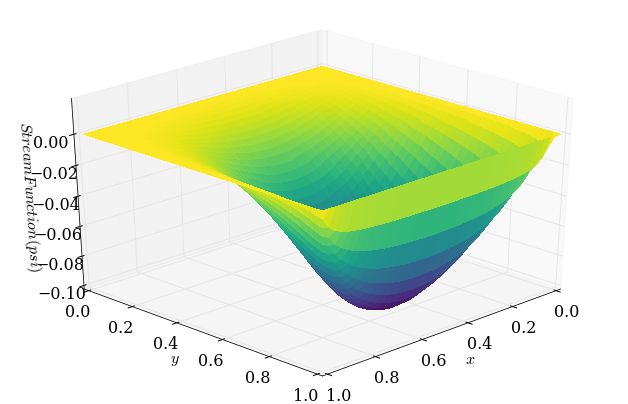

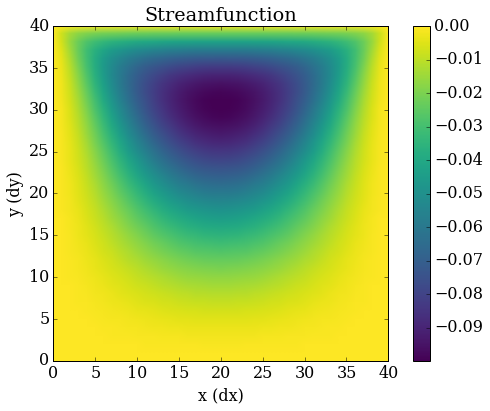

In [10]:
x = numpy.linspace(0,1,nx)
y = numpy.linspace(0,1,ny)

w0=numpy.zeros((nx,ny))
psi0=numpy.zeros((nx,ny))
w0[-1,:]=-3/dy

psi0, w0= stokesjacobi(w0.copy(),psi0.copy())
plot_3D(x,y,psi0)
colormap(x,y,psi0)

Utilisons "jit", importé au début, pour améliorer notre implémentation de la méthode de Jacobi.
Nous allons devoir utiliser des boucles pour permettre l'utilisation de Numba.

Nous voudrons stocker les valeurs de la norme pour psi au cours des itérations successives dans le but d'examiner la convergence de nos différentes méthodes, à commencer par celle-ci.
Nous faisons donc en sorte que notre fonction crée désormais une liste contenant ces valeurs.
Elle doit contenir au moins autant d'éléments que d'itérations (car on a une norme de psi calculée par itération). Nous avons vu plus haut que le nombre d'itération pour Jacobi était de 4059. Ce nombre d'itérations devant diminuer pour les méthodes suivantes, nous partirons toujours d'une liste de 4060 éléments par la suite.

In [11]:
@jit(nopython=True)
def stokesjacobi_bis(w,psi):
    '''Iteratively solves the Stokes flow equation using the Jacobi method
    
    Parameters:
    ----------
    w: 2D array of float
        Initial vorticity 
    psi: 2D array of floats
        Initial streamfunction
    Returns:
    -------
    w: Vorticity after relaxation
    psi: Streamfunction after relaxation
    '''
    
    l1norm_w = 1
    l1norm_psi=1
    wn= numpy.empty_like(w)
    psin=numpy.empty_like(psi)
    normlist=numpy.zeros
    iterations=0
    normpsi_list=numpy.zeros(4060)
  
    while (l1norm_w>l1_target or l1norm_psi>l1_target) :
        
        l1norm_w=0
        l1norm_psi=0
        
        for j in range(ny):
            for i in range(nx):
                wn[j,i] = w[j,i]
                psin[j,i] = psi[j,i]
                
    
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                w[j,i] = .25 * (wn[j,i+1] + wn[j,i-1] \
                              + wn[j+1,i] + wn[j-1,i])
        
       
                psi[j,i] = 1/(2*(dx**2 + dy**2)) * \
                        ((psin[j,i+1]+psin[j,i-1])*dy**2 +\
                        (psin[j+1,i] + psin[j-1,i])*dx**2 +\
                         wn[j,i]*dx**2*dy**2)
            
        ##B.C on the top of the square
        for i in range(nx):
            w[-1,i]=(-1/(dy)**2)*(4*psi[-2,i]-psi[-3,i]/2)-3.0/dy
            w[0,i]=(-1/(dy)**2)*(4*psi[1,i]-psi[2,i]/2)  
        for j in range(ny):
            w[j,-1]=(-1/(dx)**2)*(4*psi[j,-2]-psi[j,-3]/2)
            w[j,0]=(-1/(dx)**2)*(4*psi[j,1]-psi[j,2]/2)

        for j in range(ny):
            for i in range(nx):
                l1norm_w += numpy.abs(w[j,i] - wn[j,i])
                
                l1norm_psi += numpy.abs(psi[j,i] - psin[j,i])
                
       
        normpsi_list[iterations]= l1norm_psi
    
        iterations += 1 

    iter_list = numpy.linspace(1,iterations,iterations-1)

        
        
    print(iterations,l1norm_w,l1norm_psi)
    return psi,w,iter_list,normpsi_list,iterations

In [12]:
%%timeit

w1=numpy.zeros((ny,nx))
psi1=numpy.zeros((ny,nx))
w1[-1,:]=-3/dy

psi1,w1,iterlist_jac,normpsilist_jac,iterations_jac= stokesjacobi_bis(w1.copy(),psi1.copy())

4059 9.997482597647045e-07 2.24232961630431e-08
4059 9.997482597647045e-07 2.24232961630431e-08
4059 9.997482597647045e-07 2.24232961630431e-08
4059 9.997482597647045e-07 2.24232961630431e-08
The slowest run took 23.05 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 30.8 ms per loop


4059 9.997482597647045e-07 2.24232961630431e-08


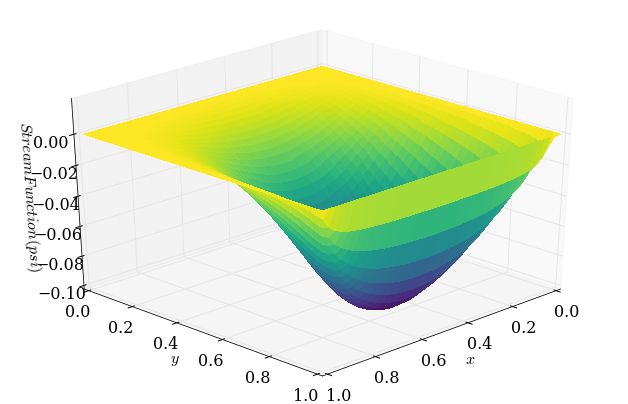

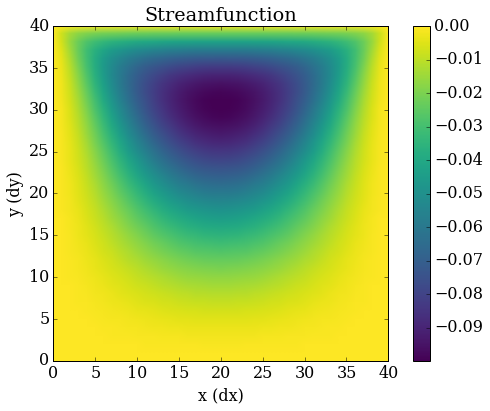

In [13]:
x = numpy.linspace(0,1,nx)
y = numpy.linspace(0,1,ny)

w1=numpy.zeros((nx,ny))
psi1=numpy.zeros((nx,ny))
w1[-1,:]=-3/dy

psi1, w1,iterlist_jac, normpsilist_jac,iterations_jac= stokesjacobi_bis(w1.copy(),psi1.copy())
plot_3D(x,y,psi1)
colormap(x,y,psi1)

## Vérification de notre solution:

Afin de vérifier qu'il s'agit de la bonne solution, nous allons extraire certaines valeurs de notre solution:

#### 1. Valeur maximum de $|\psi|$ à l'intérieur de la cavité:

In [14]:
round(numpy.max(numpy.abs(psi0[1:-1,1:-1])),4)

0.0998

#### 2. Valeur maximum de $|\omega|$ à l'intérieur de la cavité:

*Remarque: on demande $|\omega|$ à l'intérieur de la cavité mais pour obtenir la valeur voulue dans le check il faut regarder sur cet intervalle bizarre (intérieur pour x et total pour y)*

In [15]:
round(numpy.max(numpy.abs(w0[1:-1,1:-1])),4)

22.5608

#### 3. Array de psi pour y=32dy, tous les 8 valeurs de x:

In [16]:
numpy.round(psi0[32,::8], 4)

array([ 0.    , -0.0575, -0.0944, -0.0944, -0.0575,  0.    ])

## 2. Méthode de Gauss-Seidel
Cette méthode est fondée sur le même principe que l'itération de Jacobi mais au lieu de toujours utiliser les valeurs de $\omega$ et de $\psi$ de l'itération précédente, on utilise le plus possible les valeurs les plus actuelles.
En effet, lorsqu'on met à jour $\psi$ et $\omega$, on le fait dans un certain ordre: on balaie le carré des valeurs (x,y) de gauche à droite (x croissants) puis ligne par ligne de haut en bas (y croissants). 
On pourra donc itérer nos valeurs comme suit:
\begin{equation}
\omega^{k+1}_{i,j} = \frac{1}{4} \left(\omega^{k+1}_{i,j-1} + \omega^k_{i,j+1} + \omega^{k+1}_{i-1,j} + \omega^k_{i+1,j} \right)
\end{equation}
(valable seulement pour $\Delta x= \Delta y$)
\begin{equation}
\psi_{i,j}^{k+1}=\frac{(\psi_{i+1,j}^{k}+\psi_{i-1,j}^{k+1})\Delta y^2+(\psi_{i,j+1}^{k}+\psi_{i,j-1}^{k+1})\Delta x^2+\omega_{i,j}^{k}\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}
\end{equation}


Ceci devrait permettre de diminuer le nombre d'itérations nécessaires pour arriver à la solution. Cependant, on ne peut plus utiliser le calcul par les listes et on doit retourner aux boucles "for". Pour éviter que cela ne prenne trop de temps de calcul, on utilise "numba" et "jit", qui vont en fait compiler notre code et l'optimiser. 

In [17]:

@jit(nopython=True)
def stokesGauss(w,psi):
    '''Iteratively solves the Stokes flow equation using the Jacobi method
    
    Parameters:
    ----------
    w: 2D array of float
        Initial vorticity 
    psi: 2D array of floats
        Initial streamfunction
    Returns:
    -------
    w: Vorticity after relaxation
    psi: Streamfunction after relaxation
    '''
    
    l1norm_w = 1
    l1norm_psi=1
    wn = numpy.empty_like(w)
    psin=numpy.empty_like(psi)
    iterations=0
    normpsi_list=numpy.zeros(4060)
    
    
    while (l1norm_psi>l1_target or l1norm_w>l1_target):
        l1norm_w=0
        l1norm_psi=0
        
        for j in range(ny):
            for i in range(nx):
                wn[j,i] = w[j,i]
                psin[j,i] = psi[j,i]
                
    
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                w[j,i] = .25 * (w[j,i+1] + w[j,i-1] \
                              + w[j+1,i] + w[j-1,i])
        
       
                psi[j,i] = 1/(2*(dx**2 + dy**2)) * \
                        ((psi[j,i+1]+psi[j,i-1])*dy**2 +\
                        (psi[j+1,i] + psi[j-1,i])*dx**2 +\
                         w[j,i]*dx**2*dy**2)
            
        ##B.C on the top of the square
        for i in range(nx):
            w[-1,i]=(-1/(dy)**2)*(4*psi[-2,i]-psi[-3,i]/2)-3.0/dy
            w[0,i]=(-1/(dy)**2)*(4*psi[1,i]-psi[2,i]/2)  
        for j in range(ny):
            w[j,-1]=(-1/(dx)**2)*(4*psi[j,-2]-psi[j,-3]/2)
            w[j,0]=(-1/(dx)**2)*(4*psi[j,1]-psi[j,2]/2)

        for j in range(ny):
            for i in range(nx):
                l1norm_w += numpy.abs(w[j,i] - wn[j,i])
                
                l1norm_psi += numpy.abs(psi[j,i] - psin[j,i])
                
        normpsi_list[iterations]= l1norm_psi
        
    
        iterations += 1 
        
    iter_list = numpy.linspace(1,iterations,iterations-1)
        
    print(iterations,l1norm_w,l1norm_psi)
    return psi,iter_list,normpsi_list,iterations

In [18]:
%%timeit
x = numpy.linspace(0,1,nx)
y = numpy.linspace(0,1,ny)

w2=numpy.zeros((nx,ny))
psi2=numpy.zeros((nx,ny))
w2[-1,:]=-3/dy
psi2,iterlist_gauss,normpsilist_gauss,iterations_gauss= stokesGauss(w2.copy(),psi2.copy())

2120 9.944902060721704e-07 8.704372861761549e-09
2120 9.944902060721704e-07 8.704372861761549e-09
2120 9.944902060721704e-07 8.704372861761549e-09
2120 9.944902060721704e-07 8.704372861761549e-09
The slowest run took 11.80 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 32.2 ms per loop


In [19]:
x = numpy.linspace(0,1,nx)
y = numpy.linspace(0,1,ny)

w2=numpy.zeros((nx,ny))
psi2=numpy.zeros((nx,ny))
w2[-1,:]=-3/dy
psi2,iterlist_gauss,normpsilist_gauss,iterations_gauss= stokesGauss(w2.copy(),psi2.copy())


2120 9.944902060721704e-07 8.704372861761549e-09


array([ 0.    , -0.0575, -0.0944, -0.0944, -0.0575,  0.    ])

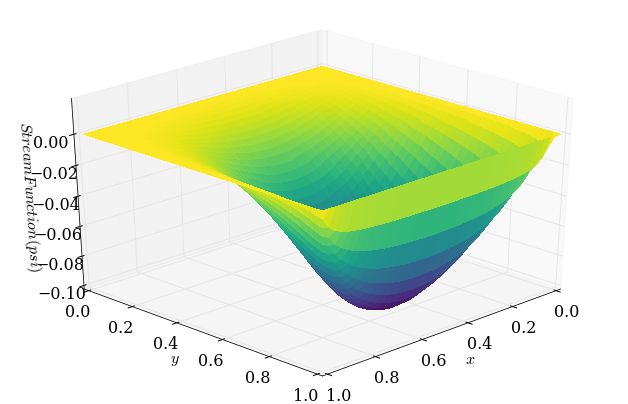

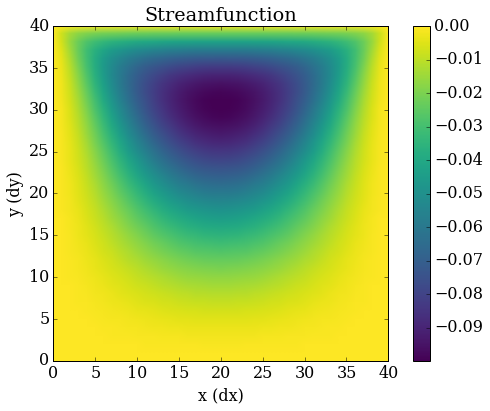

In [20]:
plot_3D(x,y,psi2)
colormap(x,y,psi2)
numpy.round(psi2[32,::8], 4)

## 3. Méthode SOR 

In [84]:
@jit(nopython=True)
def stokesSOR(w,psi,omega):
   
    l1norm_w = 1
    l1norm_psi=1
    wn = numpy.empty_like(w)
    psin=numpy.empty_like(psi)
    iterations=0
    normpsi_list=numpy.zeros(4060)
    
    while (l1norm_psi>l1_target or l1norm_w>l1_target):
        l1norm_w=0
        l1norm_psi=0
        
        for j in range(ny):
            for i in range(nx):
                wn[j,i] = w[j,i]
                psin[j,i] = psi[j,i]
                
    
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                w[j,i] = (1-omega)*wn[j,i] + omega*.25 * (wn[j,i+1] + w[j,i-1] + wn[j+1,i] + w[j-1,i])
        
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                psi[j,i] = (1-omega)*psi[j,i]+ (omega/(2*(dx**2 + dy**2))) * \
                        ((psin[j,i+1]+psi[j,i-1])*dy**2 +\
                        (psin[j+1,i] + psi[j-1,i])*dx**2 +\
                         w[j,i]*dx**2*dy**2)
            
        ##B.C on the edge of the square
        for i in range(nx):
            w[-1,i]=(-1/(dy)**2)*(4*psi[-2,i]-psi[-3,i]/2)-3.0/dy
            w[0,i]=(-1/(dy)**2)*(4*psi[1,i]-psi[2,i]/2)  
        for j in range(ny):
            w[j,-1]=(-1/(dx)**2)*(4*psi[j,-2]-psi[j,-3]/2)
            w[j,0]=(-1/(dx)**2)*(4*psi[j,1]-psi[j,2]/2)
           
        for j in range(ny):
            for i in range(nx):
                l1norm_w += numpy.abs(w[j,i] - wn[j,i])
                
                l1norm_psi += numpy.abs(psi[j,i] - psin[j,i])
                
        normpsi_list[iterations]= l1norm_psi
        
    
        iterations += 1 
        
    iter_list = numpy.linspace(1,iterations,iterations-1)
        
    print(iterations,l1norm_w,l1norm_psi)
    return psi,w,iter_list,normpsi_list,iterations

In [85]:
%%timeit
x = numpy.linspace(0,1,nx)
y = numpy.linspace(0,1,ny)

w=numpy.zeros((nx,ny))
psi3=numpy.zeros((nx,ny))
w[-1,:]=-3/dy
psi3,w,iterlist_SOR,normpsilist_SOR,iterations_SOR= stokesSOR(w.copy(),psi3.copy(),1.4345)

892 9.97320597100385e-07 2.5658381358657092e-08
892 9.97320597100385e-07 2.5658381358657092e-08
892 9.97320597100385e-07 2.5658381358657092e-08
892 9.97320597100385e-07 2.5658381358657092e-08
The slowest run took 19.53 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 22.5 ms per loop


892 9.973203104338612e-07 2.56583854682931e-08


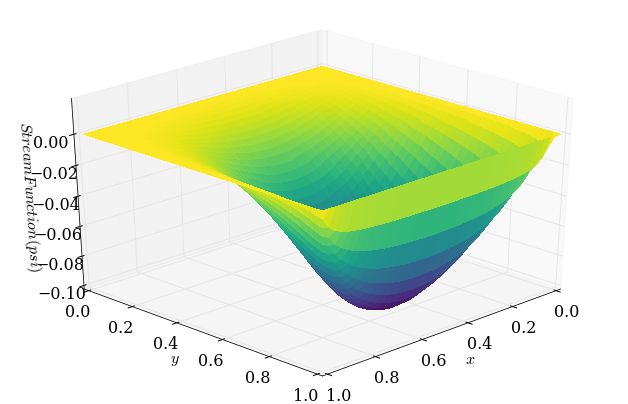

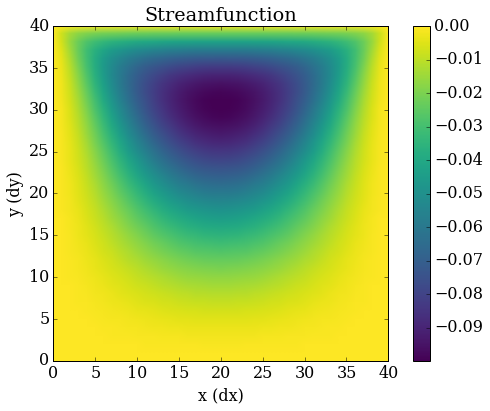

In [86]:
x = numpy.linspace(0,1,nx)
y = numpy.linspace(0,1,ny)

w3=numpy.zeros((nx,ny))
psi3=numpy.zeros((nx,ny))
w3[:,-1]=-3/dy
psi3,w3,iterlist_SOR,normpsilist_SOR,iterations_SOR= stokesSOR(w3.copy(),psi3.copy(),1.4345)
plot_3D(x,y,psi3)
numpy.round(psi3[32,::8], 4)
colormap(x,y,psi3)

## Etude de la convergence des différentes méthodes:

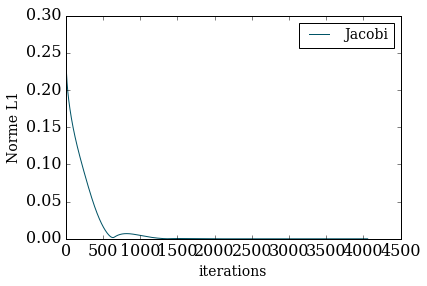

In [24]:
pyplot.plot(iterlist_jac,normpsilist_jac[:iterations_jac-1], color='#005366',label='Jacobi')
pyplot.xlabel('iterations', fontsize=14)
pyplot.ylabel('Norme L1', fontsize=14)
pyplot.legend(loc='upper right',fontsize=14)
pyplot.close;

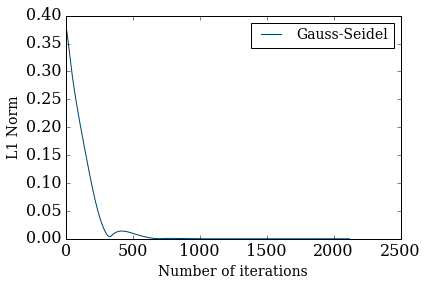

In [25]:
pyplot.plot(iterlist_gauss,normpsilist_gauss[:iterations_gauss-1], color='#004366',label='Gauss-Seidel')
pyplot.xlabel('Number of iterations', fontsize=14)
pyplot.ylabel('L1 Norm', fontsize=14)
pyplot.legend(loc='upper right',fontsize=14)
pyplot.close;

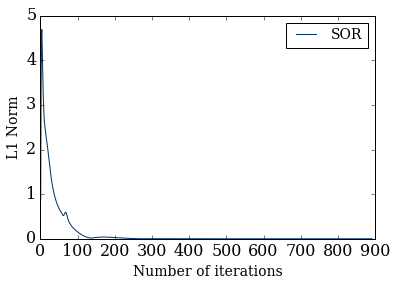

In [26]:
pyplot.plot(iterlist_SOR,normpsilist_SOR[:iterations_SOR-1], color='#003366',label='SOR')
pyplot.xlabel('Number of iterations', fontsize=14)
pyplot.ylabel('L1 Norm', fontsize=14)
pyplot.legend(loc='upper right',fontsize=14)
pyplot.close;

**Comparaison de la convergence:**

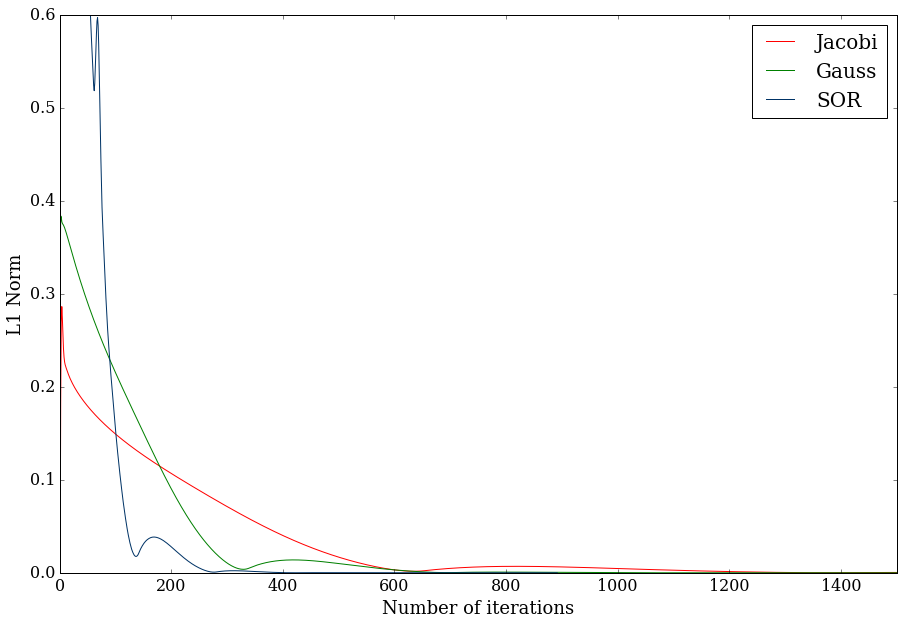

In [27]:
pyplot.figure(figsize=(15,10))
pyplot.plot(iterlist_jac,normpsilist_jac[:iterations_jac-1], color='red',label='Jacobi')
pyplot.plot(iterlist_gauss,normpsilist_gauss[:iterations_gauss-1], color='green',label='Gauss')
pyplot.plot(iterlist_SOR,normpsilist_SOR[:iterations_SOR-1], color='#003366',label='SOR')
pyplot.xlabel('Number of iterations', fontsize=18)
pyplot.ylabel('L1 Norm', fontsize=18)
pyplot.ylim(0,0.6) 
pyplot.xlim(0,1500)
pyplot.legend(loc='upper right',fontsize=20)
pyplot.close;

**Bosses: il est possible que ça corresponde au moments où l'information "rebondit" sur les bords => à vérifier**

## 4. Steepest Descent

On considère l'équation comme une équation de matrice Ax=b.
Dans notre cas, on aura deux systèmes d'équations couplés:
$$A\omega=0$$
$$A\psi=-\omega$$
où $$A=\nabla^{2}$$
En discrétisant cet opérateur, on obtient que 

$$\nabla^{2}p=\frac{p_{i+1,j}^{k}-2p_{i,j}^{k}+p_{i-1,j}^{k}}{\Delta x^2}+\frac{p_{i,j+1}^{k}-2 p_{i,j}^{k}+p_{i,j-1}^{k}}{\Delta y^2}$$
Pour n'importe quelle fonction p.

## Code:

In [75]:
def steep_des(w,psi):
    

    l1norm_w = 1
    l1norm_psi=1

    Aresi_w=numpy.zeros((ny,nx))
    Aresi_psi= numpy.zeros((ny,nx))
    residual_w=numpy.zeros((ny,nx))
    residual_psi=numpy.zeros((ny,nx))
    iterations=0
    normpsi_list=numpy.zeros(5400)

    while (l1norm_psi>l1_target or l1norm_w>l1_target) :
        l1norm_w = 0
        l1norm_psi= 0
        
        wn = w.copy()
        psin=psi.copy()
        
            
        residual_w[1:-1,1:-1]= 4*wn[1:-1,1:-1] - wn[1:-1,2:] - wn[1:-1,:-2] - wn[2:, 1:-1] - wn[:-2, 1:-1]
        
        Aresi_w[1:-1,1:-1] = -4*residual_w[1:-1,1:-1] + \
                         residual_w[1:-1,2:] + residual_w[1:-1,:-2] + residual_w[2:, 1:-1] + residual_w[:-2, 1:-1]
        
        numw = numpy.sum(residual_w*residual_w)
        denw = numpy.sum(residual_w*Aresi_w)
        alphaw = numw/denw
        
        w= wn + alphaw*residual_w
        
        ##B.C on the edge of the square
        w[-1,:]=(-1/(dx)**2)*(4*psi[-2,:]-psi[-3,:]/2)-3.0/dy
        w[0,:]=(-1/(dx)**2)*(4*psi[1,:]-psi[2,:]/2) 
        w[:,-1]=(-1/(dy)**2)*(4*psi[:,-2]-psi[:,-3]/2)
        w[:,0]=(-1/(dy)**2)*(4*psi[:,1]-psi[:,2]/2)
         
        
        residual_psi[1:-1,1:-1] = -w[1:-1,1:-1]*(dx**2)+4*psin[1:-1,1:-1]\
                                -(psin[1:-1,2:]+psin[1:-1,:-2] +\
                                psin[2:,1:-1] + psin[:-2,1:-1])
        
                                                  
        Aresi_psi[1:-1,1:-1] = -4*residual_psi[1:-1,1:-1] + residual_psi[1:-1,2:] + residual_psi[1:-1,:-2] +\
                                residual_psi[2:,1:-1] + residual_psi[:-2,1:-1]
        

        numpsi = numpy.sum(residual_psi*residual_psi)
        denpsi = numpy.sum(residual_psi*Aresi_psi)
        alphapsi = numpsi/denpsi
            
       
        psi = psin + alphapsi*residual_psi
        

        l1norm_w=L1norm(w,wn)
        l1norm_psi=L1norm(psi,psin)
        
        normpsi_list[iterations]= l1norm_psi
        
        iterations += 1 
        
        
        
    iter_list = numpy.linspace(1,iterations,iterations-1)
    print('Number of iterations: {0:d}'.format(iterations))
    print('L1 Norm for omega:',l1norm_w)
    print('L1 Norm for psi: ',l1norm_psi)
    return psi,w,iter_list,normpsi_list,iterations

In [76]:
x5 = numpy.linspace(0,1,nx)
y5 = numpy.linspace(0,1,ny)

In [77]:
w5=numpy.zeros((ny,nx))
psi5=numpy.zeros((ny,nx))
w5[-1,:]=-3/dy

Number of iterations: 4032
L1 Norm for omega: 9.997536733e-07
L1 Norm for psi:  1.86198122927e-08


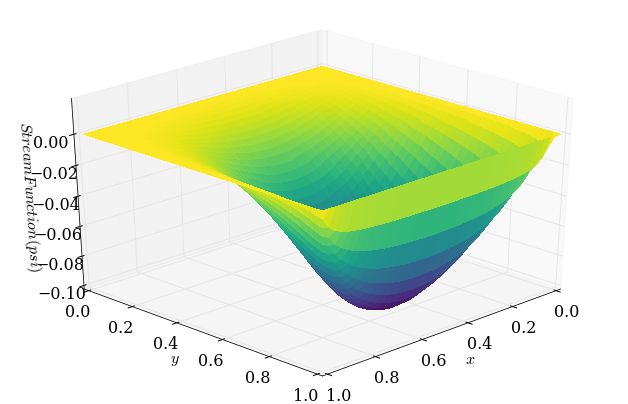

In [78]:
psi5,w5,iterlist_Steep,normpsilist_Steep,iterations5= steep_des(w5.copy(),psi5.copy())
plot_3D(x5,y5,psi5)

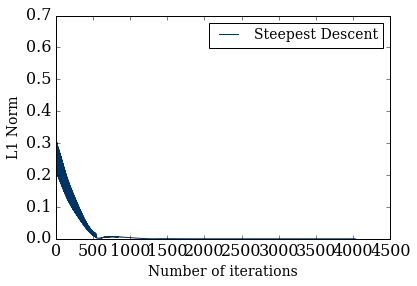

In [32]:
pyplot.plot(iterlist_Steep,normpsilist_Steep[:iterations5-1], color='#003366',label='Steepest Descent')
pyplot.xlabel('Number of iterations', fontsize=14)
pyplot.ylabel('L1 Norm', fontsize=14)
pyplot.legend(loc='upper right',fontsize=14)
pyplot.close;

In [33]:
print(numpy.max(numpy.abs(psi5[1:-1,1:-1])))

0.0998451719022


Ca converge mais ça met autant d'itérations que Jacobi

## 5. Conjugate gradient

In [34]:
def conjugate_gradient(psi, w):
    '''Performs cg relaxation
    Assumes Dirichlet boundary conditions p=0
    
    Parameters:
    ----------
    p : 2D array of floats
        Initial guess
    b : 2D array of floats
        Source term
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    l2_target: float
        exit criterion
        
    Returns:
    -------
    p: 2D array of float
        Distribution after relaxation
    '''
    ny, nx = psi.shape
    rw  = numpy.zeros((ny,nx)) # residual
    Adw  = numpy.zeros((ny,nx)) # to store result of matrix multiplication 
    rpsi  = numpy.zeros((ny,nx)) # residual
    Adpsi  = numpy.zeros((ny,nx)) # to store result of matrix multiplication 
    Apsi  = numpy.zeros((ny,nx)) 
    
    l1norm_w = 1
    l1norm_psi = 1
    iterations= 0
    
    # Step-0 We compute the initial residual and 
    # the first search direction is just this residual
    
    rw[1:-1,1:-1] =(4*w[1:-1,1:-1] - w[1:-1,2:] - w[1:-1,:-2] - w[2:, 1:-1] - w[:-2, 1:-1])/(dx**2)
    dw = rw.copy()
    rhow = numpy.sum(rw*rw)
    Adw[1:-1,1:-1] = (-4*dw[1:-1,1:-1]+dw[1:-1,2:]+dw[1:-1,:-2]+dw[2:, 1:-1] + dw[:-2, 1:-1])/(dx**2)
    sigmaw = numpy.sum(dw*Adw)
    alphaw = rhow/sigmaw   
    
    rpsi[1:-1,1:-1] = -(w[1:-1,1:-1]+alphaw*dw[1:-1,1:-1])
                        
    dpsi = rpsi.copy()   
    rhopsi = numpy.sum(rpsi*rpsi)                                              
    Adpsi[1:-1,1:-1] = (-4*dpsi[1:-1,1:-1] + dpsi[1:-1,2:] + dpsi[1:-1,:-2] +dpsi[2:,1:-1] +\
                        dpsi[:-2,1:-1])/(dx**2)
    sigmapsi = numpy.sum(rpsi*Adpsi)
    alphapsi=rhopsi/sigmapsi
    
    # Iterations
    #l1norm_w>l1_target or l1norm_psi>l1_target
    while (l1norm_w>l1_target or l1norm_psi>l1_target):
        wn=w.copy()
        rwn = rw.copy()
        dwn = dw.copy()
        
        psin=psi.copy()
        rpsin=rpsi.copy()
        dpsin=dpsi.copy()
        
        w = wn + alphaw*dwn
 
        # BC
        w[-1,:]=(-1)*(4*psi[-2,:]-psi[-3,:]/2.0)-3.0/dy
        w[0,:]=(-1)*(4*psi[1,:]-psi[2,:]/2.0)
        w[:,-1]=(-1)*(4*psi[:,-2]-psi[:,-3]/2.0)
        w[:,0]=(-1)*(4*psi[:,1]-psi[:,2]/2.0)
        
        rw = rwn-alphaw*Adw
        rhop1_w = numpy.sum(rw*rw)
        betaw = rhop1_w / rhow
        rhow = rhop1_w
        dw = rw + betaw*dwn
        Adw[1:-1,1:-1] = (-4*dw[1:-1,1:-1] + dw[1:-1,2:] + dw[1:-1,:-2] + dw[2:, 1:-1] + dw[:-2, 1:-1])/(dx**2)
        sigmaw = numpy.sum(dw*Adw)
        alphaw=rhow/sigmaw

        psi = psin + alphapsi*dpsin
        
        rpsi = rpsin - alphapsi*Adpsi - alphaw*dw
        rhop1_psi = numpy.sum(rpsi*rpsi)
        betapsi = rhop1_psi / rhopsi
        rhopsi = rhop1_psi
        dpsi = rpsi + betapsi*dpsin
        Adpsi[1:-1,1:-1] = (-4*dpsi[1:-1,1:-1] + dpsi[1:-1,2:] + dpsi[1:-1,:-2] +\
                                dpsi[2:,1:-1] + dpsi[:-2,1:-1])/(dx**2)
        
        sigmapsi = numpy.sum(dpsi*Adpsi)
        alphapsi=rhopsi/sigmapsi                                                 
        

        l1norm_w=L1norm(wn,w)
        l1norm_psi=L1norm(psin,psi)
        iterations += 1
    
    print('Number of CG iterations: {0:d}'.format(iterations))
    return psi    


In [35]:
x6 = numpy.linspace(0,1,nx)
y6 = numpy.linspace(0,1,ny)

In [36]:
w6=numpy.zeros((ny,nx))
psi6=numpy.zeros((ny,nx))
w6[-1,:]=-3/dy

Number of CG iterations: 1719


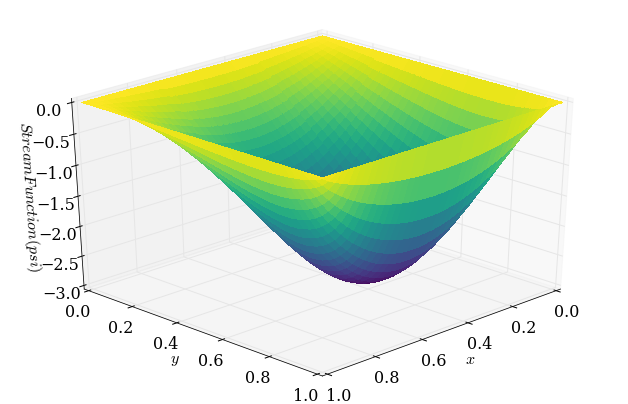

In [37]:
psi6=conjugate_gradient(psi6.copy(),w6.copy())
plot_3D(x6,y6,psi6)

In [38]:
print(numpy.max(numpy.abs(psi6[1:-1,1:-1])))

2.6371334821


## Essai pour comprendre le problème du grand nombre d'itérations:

In [39]:
def conjugate_gradient_2d(p):
    '''Performs cg relaxation
    Assumes Dirichlet boundary conditions p=0
    
    Parameters:
    ----------
    p : 2D array of floats
        Initial guess
    b : 2D array of floats
        Source term
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    l2_target: float
        exit criterion
        
    Returns:
    -------
    p: 2D array of float
        Distribution after relaxation
    '''
    ny, nx = p.shape
    r  = numpy.zeros((ny,nx)) # residual
    Ad  = numpy.zeros((ny,nx)) # to store result of matrix multiplication 
    
    l2_norm = 1
    iterations = 0
    
    # Step-0 We compute the initial residual and 
    # the first search direction is just this residual
    
    r[1:-1,1:-1] = 4*p[1:-1,1:-1] - \
        p[1:-1,2:] - p[1:-1,:-2] - p[2:, 1:-1] - p[:-2, 1:-1]
    d = r.copy()
    rho = numpy.sum(r*r)
    Ad[1:-1,1:-1] = -4*d[1:-1,1:-1]+d[1:-1,2:]+d[1:-1,:-2]+\
        d[2:, 1:-1] + d[:-2, 1:-1]
    sigma = numpy.sum(d*Ad)
    
    # Iterations
    while l2_norm > l1_target:

        pk = p.copy()
        rk = r.copy()
        dk = d.copy()
        
        alpha = rho/sigma

        p = pk + alpha*dk
        r = rk- alpha*Ad
        
        rhop1 = numpy.sum(r*r)
        beta = rhop1 / rho
        rho = rhop1
        
        d = r + beta*dk
        Ad[1:-1,1:-1] = -4*d[1:-1,1:-1] + d[1:-1,2:] + d[1:-1,:-2] + \
            d[2:, 1:-1] + d[:-2, 1:-1]
        sigma = numpy.sum(d*Ad)
        
        # BCs are automatically enforced
        
        l2_norm = L1norm(pk,p)
        iterations += 1
    
    print('Number of CG iterations: {0:d}'.format(iterations))
    return p    


Number of CG iterations: 126


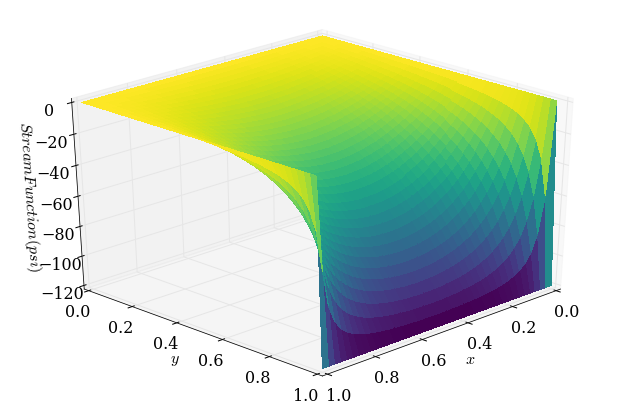

In [40]:
x7 = numpy.linspace(0,1,nx)
y7 = numpy.linspace(0,1,ny)
w7=numpy.zeros((ny,nx))
w7[-1,:]=-3/dy
w7=conjugate_gradient_2d(w7.copy())
plot_3D(x7,y7,w7)

J'ai repris exactement le code du prof et j'ai utilisé la fonction w de notre problème, on voit qu'il faut 126 itérations dans ce cas, au lieu de 2 pour le prof, juste à cause des conditions initiales: pour moi, ce sont elles qui sont responsable de la convergence lente du problème (j'aurai tendance à dire que le problème vient de ce que A n'est pas définie positive)

## Equation biharmonique
\begin{equation}
\nabla^4\psi=0\\
\Leftrightarrow \frac{\partial^4 \psi}{\partial y^4} + 2\frac{\partial^4 \psi}{\partial y^2 \partial x^2}+\frac{\partial^4 \psi}{\partial x^4}=0\\
\Leftrightarrow \left(\frac{\psi_{i-2,j} - 4\psi_{i-1,j} +6\psi_{i,j} - 4\psi_{i+1,j} + \psi_{i+2,j}}{\Delta x^4}\right) +2\left(\frac{\Big[\psi_{i-1,j-1} - 2\psi_{i-1,j} + \psi_{i-1,j+1}\Big] - 2\Big[\psi_{i,j-1} - 2\psi_{i,j} + \psi_{i,j+1}\Big]+\Big[\psi_{i+1,j-1} - 2\psi_{i+1,j} + \psi_{i+1,j+1}\Big]}{\Delta x^2 \Delta y^2}\right)
+\left(\frac{\psi_{i,j-2} - 4\psi_{i,j-1} +6\psi_{i,j} - 4\psi_{i,j+1} + \psi_{i,j+2}}{\Delta y^4}\right)=0
\end{equation}

**Conditions au bord:**

TOP:
\begin{equation}
\psi=0 \Leftrightarrow \psi_{i,ny-1}=0\\
\frac{\partial \psi}{\partial y}=1 \Leftrightarrow \psi_{i,ny-2}=\frac{\psi_{i,ny-3}}{4} - \frac{\Delta y}{2}
\end{equation}
BOTTOM:
\begin{equation}
\psi=0\Leftrightarrow \psi_{i,0}=0\\
\frac{\partial \psi}{\partial y}=0 \Leftrightarrow \psi_{i,1}=\frac{\psi_{i,2}}{4}
\end{equation}
LEFT:
\begin{equation}
\psi=0\Leftrightarrow \psi_{0,j}=0\\
\frac{\partial \psi}{\partial x}=0 \Leftrightarrow \psi_{1,j}=\frac{\psi_{2,j}}{4}
\end{equation}
RIGHT:
\begin{equation}
\psi=0\Leftrightarrow \psi_{nx-1,j}=0\\
\frac{\partial \psi}{\partial x}=0 \Leftrightarrow \psi_{nx-2,j}=\frac{\psi_{nx-3,j}}{4}
\end{equation}

Equation biharmonique: essai à 1D

In [44]:
def matrixA_1D(psi):
    n=psi.shape
    Apsi = numpy.zeros(n)
    b = numpy.zeros(n)
    b[-4]=1/(2*dx**3)
    b[-3]=-2/(dx**3)
  
    Apsi[4:-4]=(psi[2:-6]-4*psi[3:-5]+6*psi[4:-4]-4*psi[5:-3]+psi[6:-2])/(dx**4)
    Apsi[2]=(5*psi[2]-4*psi[3]+psi[4])/(dx**4)
    Apsi[3]=(-15/4*psi[2]+6*psi[3]-4*psi[4]+psi[5])/(dx**4)
    Apsi[-4]=(psi[-6]-4*psi[-5]+6*psi[-4]-15/4*psi[-3])/(dx**4)
    Apsi[-3]=(psi[-5]-4*psi[-4]+5*psi[-3])/(dx**4)
    
    return Apsi,b

In [45]:
def biharmonic1D(p):
    n= p.shape
    r  = numpy.zeros(n) # residual
    Ad  = numpy.zeros(n) # to store result of matrix multiplication 
    b = matrixA_1D(p)[1]
    l1_norm = 1
    iterations = 0
    
    # Step-0 We compute the initial residual and 
    # the first search direction is just this residual
    Ad  = matrixA_1D(p)[0]
    r[2:-2] = b[2:-2]- Ad[2:-2]
    d = r.copy()
    rho = numpy.sum(r*r)
    Ad = matrixA_1D(d)[0]
    sigma = numpy.sum(d*Ad)
    
    # Iterations
    while l1_norm > l1_target:

        pk = p.copy()
        rk = r.copy()
        dk = d.copy()
        
        alpha = rho/sigma

        p = pk + alpha*dk
        r = rk- alpha*Ad
        
        rhop1 = numpy.sum(r*r)
        beta = rhop1 / rho
        rho = rhop1
        
        d = r + beta*dk
        Ad = matrixA_1D(d)[0]
        sigma = numpy.sum(d*Ad)
        
        # BC
        p[1]=p[2]/4
        p[-2]=p[-3]/4-dx/2
        
        l1_norm = L1norm(pk,p)
        iterations += 1
    
    print('Number of CG iterations: {0:d}'.format(iterations))
    return p    

In [46]:
x=numpy.linspace(0,1,nx)
psi=numpy.zeros(nx)
psiup=biharmonic1D(psi)

Number of CG iterations: 448


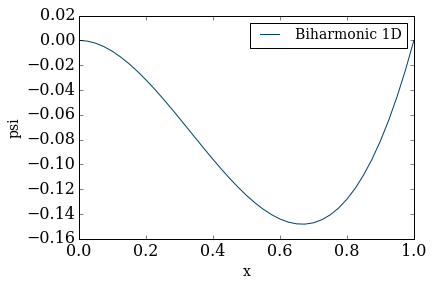

In [47]:
pyplot.plot(x,psiup, color='#004366',label='Biharmonic 1D')
pyplot.xlabel('x', fontsize=14)
pyplot.ylabel('psi', fontsize=14)
pyplot.legend(loc='upper right',fontsize=14)
pyplot.close;

In [62]:
def matrixA_2D(psi):
    ny, nx = psi.shape
    Apsi = numpy.zeros((ny,nx))
    b = numpy.zeros((ny,nx))
    b[-4,4:-4]=1/(2*dx**3)
    b[-3,4:-4]=-2/(dx**3)
    
    
    Apsi[4:-4,4:-4] = ((psi[4:-4,2:-6]+psi[4:-4,6:-2]+psi[2:-6,4:-4]+psi[6:-2,4:-4])\
                    +2*(psi[3:-5,3:-5]+psi[5:-3,3:-5]+psi[3:-5,5:-3]+psi[5:-3,5:-3])\
                    -8*(psi[4:-4,3:-5]+psi[4:-4,5:-3]+psi[3:-5,4:-4]+psi[5:-3,4:-4])\
                    +20*psi[4:-4,4:-4])/(dx**4)
                
    #Matrix on the edge

    #Right:
    Apsi[4:-4,-3] = ((psi[4:-4,-5]+psi[2:-6,-3]+psi[6:-2,-3])\
                    +2*(psi[3:-5,-4]+psi[5:-3,-4]+psi[3:-5,-3]/4+psi[5:-3,-3]/4)\
                    -8*(psi[4:-4,-4]+psi[4:-4,-3]/4+psi[3:-5,-3]+psi[5:-3,-3])\
                    +20*psi[4:-4,-3])/(dx**4)
    Apsi[4:-4,-4] = ((psi[4:-4,-6]+psi[4:-4,-3]/4+psi[2:-6,-4]+psi[6:-2,-4])\
                    +2*(psi[3:-5,-5]+psi[5:-3,-5]+psi[3:-5,-3]+psi[5:-3,-3])\
                    -8*(psi[4:-4,-5]+psi[4:-4,-3]+psi[3:-5,-4]+psi[5:-3,-4])\
                    +20*psi[4:-4,-4])/(dx**4)
    #Left:
    Apsi[4:-4,2] = ((psi[4:-4,4]+psi[2:-6,2]+psi[6:-2,2])\
                    +2*(psi[3:-5,2]/4+psi[5:-3,2]/4+psi[3:-5,3]+psi[5:-3,3])\
                    -8*(psi[4:-4,2]/4+psi[4:-4,3]+psi[3:-5,2]+psi[5:-3,2])\
                    +20*psi[4:-4,2])/(dx**4)
    Apsi[4:-4,3] = ((psi[4:-4,2]/4+psi[4:-4,5]+psi[2:-6,3]+psi[6:-2,3])\
                    +2*(psi[3:-5,2]+psi[5:-3,2]+psi[3:-5,4]+psi[5:-3,4])\
                    -8*(psi[4:-4,2]+psi[4:-4,4]+psi[3:-5,3]+psi[5:-3,3])\
                    +20*psi[4:-4,3])/(dx**4)
    #Top:
    Apsi[-3,4:-4] = ((psi[-3,2:-6]+psi[-3,6:-2]+psi[-5,4:-4])\
                    +2*(psi[-4,3:-5]+psi[-3,3:-5]/4+psi[-4,5:-3]+psi[-3,5:-3]/4)\
                    -8*(psi[-3,3:-5]+psi[-3,5:-3]+psi[-4,4:-4]+psi[-3,4:-4]/4)\
                    +20*psi[-3,4:-4])/(dx**4)
    Apsi[-4,4:-4] = ((psi[-4,2:-6]+psi[-4,6:-2]+psi[-6,4:-4]+psi[-3,4:-4]/4)\
                    +2*(psi[-5,3:-5]+psi[-3,3:-5]+psi[-5,5:-3]+psi[-3,5:-3])\
                    -8*(psi[-4,3:-5]+psi[-4,5:-3]+psi[-5,4:-4]+psi[-3,4:-4])\
                    +20*psi[-4,4:-4])/(dx**4)
    #Bottom:
    Apsi[2,4:-4] = ((psi[2,2:-6]+psi[2,6:-2]+psi[4,4:-4])\
                    +2*(psi[2,3:-5]/4+psi[3,3:-5]+psi[2,5:-3]/4+psi[3,5:-3])\
                    -8*(psi[2,3:-5]+psi[2,5:-3]+psi[2,4:-4]/4+psi[3,4:-4])\
                    +20*psi[2,4:-4])/(dx**4)
    Apsi[3,4:-4] = ((psi[3,2:-6]+psi[3,6:-2]+psi[2,4:-4]/4+psi[5,4:-4])\
                    +2*(psi[2,3:-5]+psi[4,3:-5]+psi[2,5:-3]+psi[4,5:-3])\
                    -8*(psi[3,3:-5]+psi[3,5:-3]+psi[2,4:-4]+psi[4,4:-4])\
                    +20*psi[3,4:-4])/(dx**4)

    
    return Apsi,b

In [63]:
def Biharmonic2D(psi):

    ny, nx = psi.shape
    r  = numpy.zeros((ny,nx)) # residual
    Ad  = numpy.zeros((ny,nx)) # to store result of matrix multiplication 
    b = matrixA_2D(psi)[1]
    
    l1_norm = 1
    iterations = 0
    
    # Step-0 We compute the initial residual and 
    # the first search direction is just this residual
    Ad = matrixA_2D(psi)[0]
    r = b - Ad
    d = r.copy()
    rho = numpy.sum(r*r)
    Ad = matrixA_2D(d)[0]
    sigma = numpy.sum(d*Ad)
    
    # Iterations
    while l1_norm > l1_target:

        psik = psi.copy()
        rk = r.copy()
        dk = d.copy()
        
        alpha = rho/sigma

        psi = psik + alpha*dk
        
        r = rk- alpha*Ad
        
        rhop1 = numpy.sum(r*r)
        beta = rhop1 / rho
        rho = rhop1
        
        d = r + beta*dk
        Ad = matrixA_2D(d)[0]
        sigma = numpy.sum(d*Ad)
    
        
        l1_norm = L1norm(psik,psi)
        iterations += 1
             #BC
        psi[-2,:]=psi[-3,:]/4-dy/2
        psi[:,-2]=psi[:,-3]/4
        psi[:,1]=psi[:,2]/4
        psi[1,:]=psi[2,:]/4
        
    print('Number of CG iterations: {0:d}'.format(iterations))
    return psi   

Number of CG iterations: 819


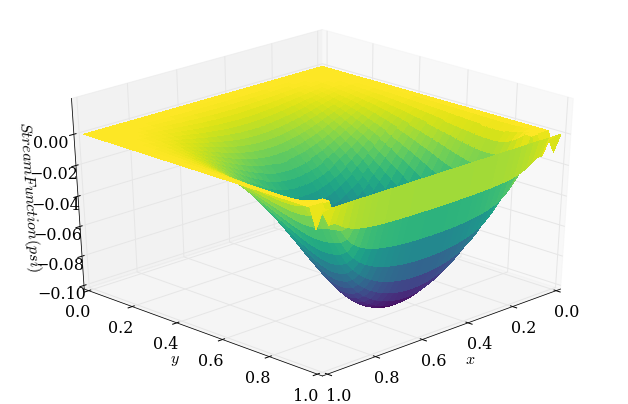

In [64]:
x9 = numpy.linspace(0,1,nx)
y9 = numpy.linspace(0,1,ny)
psi9=numpy.zeros((ny,nx))
psi9=Biharmonic2D(psi9.copy())
plot_3D(x9,y9,psi9)

In [65]:
print(numpy.max(numpy.abs(psi9[1:-1,1:-1])))

0.0983651693301


In [66]:
numpy.round(psi9[32,::8], 4)

array([ 0.    , -0.0505, -0.0926, -0.0926, -0.0505,  0.    ])